# Who will be the Mormon prophet in year 2028?

# Summary October 3, 2015

  * Method 1: Winner takes all predicts Dallin H. Oaks
  * Method 2: Monte-Carlo simulation predicts Jeffery R. Holland with an approx. 25% chance.
  * Method 3: Subjectively adjusted health predicts Dallin H. Oaks with an approx. 28% chance.

# Summary January 1, 2018

  * Method 1: Winner takes all predicts David A. Bednar in 2028 and Russle M. Nelson lives to 2020
  * Method 2: Monte-Carlo simulation predicts David A. Bednar in 2028 with approx. 26% chance and Russle M. Nelson lives to 2020 with an approx. 42% chance.
  * Method 3: Subjectively adjusted health predicts Other in 2028 with approx. 99% chance and Russle M. Nelson lives to 2022 with approx. 25% chance.

## Notes
  
  * Adds qgrid dependency

## Overview

It just so happens that there's a a convenient pattern to whom is usually called to be the next prophet of *The Church of Jesus Christ of Latter-day Saints*. For most of the 20th century and all of the 21st century so far, the pattern has been that the prophet of the church is the most senior apostle (by date of calling to the Quorum of the Twelve) becomes the prophet when the previous prophet dies. There are 15 of these apostles at any given time: three in the "First Presidency", comprising the prophet and his two counselors, and twelve in the Quorum of the Twelve Apostles.

Given the ages of the apostles and some average actuarial life tables (which we use here despite knowing that these men are generally far healthier than the average population), we can fairly easily calculate the likely age of death of the current apostles and rank them by seniority to find some likely scenarios for new prophets.

In [17]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import pandas as pd
import qgrid as qg
from datetime import datetime, timedelta
from collections import defaultdict
import seaborn as sns
rcParams['figure.figsize'] = (10.0, 2.0)
sns.set(style="darkgrid")

In [3]:
now = datetime.now()
CURRENT_YEAR = now.year

Here we load some actuarial life tables which give the population-level probability of death at any particular age.

In [4]:
full_life_table = pd.read_csv('../data/life_table.csv')
full_life_table.set_index('Age',inplace=True)

full_life_table[80:99]

,M,F
Age,,
80,0.061620,0.043899
81,0.068153,0.048807
82,0.075349,0.054374
83,0.083230,0.060661
84,0.091933,0.067751
85,0.101625,0.075729
86,0.112448,0.084673
87,0.124502,0.094645
88,0.137837,0.105694


In [5]:
# grab the values for the "Male" column
prob_death = full_life_table.M.values

It would be slightly more convient to work with these values if we knew, for a man of any particular age, the probability of being alive at any age. We calculate a new life table which has along each row $x$ the probability that a man of age $x$ will live to reach age $y$.

In [6]:
# Create a new life table
l = len(prob_death)
life_table = np.ones((l,l))
for i in range(0,l,1):
    for j in range(i,l,1):
        life_table[i][j]=np.prod(1 - prob_death[i:j+1])

In [30]:
# Load current apostle ages and seniority
apostle_data = pd.read_csv('../data/apostles.csv', parse_dates=['Birth', 'Twelve', 'Ordained'])
now = pd.Timestamp(datetime.now())
apostle_data['Current Age'] = (now - apostle_data['Birth']).astype('<m8[Y]')
ad = qg.QGridWidget(df=apostle_data, show_toolbar=True)
ad

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defaultColumnWidth': 150, 'rowHeight': 28, 'enableColumnReorder': False, 'enableTextSelectionOnCells': True, 'editable': True, 'autoEdit': False, 'explicitInitialization': True, 'maxVisibleRows': 15, 'minVisibleRows': 8}, precision=5, show_toolbar=True)

### Helper class

For programming convenience, this class captures some simple calculations we will need to do for each prophet.

In [31]:
class Apostle:
    def __init__(self,name,birth,twelve,ordained,seniority):
        self.name=name
        self.birth=birth
        self.twelve=twelve
        self.ordained=ordained
        self.seniority=seniority
    
    def __str__(self):
        return self.name
    
    def age(self,year):
        """Return the apostle's age in a particular year."""
        return year-self.birth.year
    
    def current_age(self):
        """Return the apostle's age in the current year."""
        current_year = datetime.now().year
        return self.age(current_year)
    
    def most_probable_death_year(self,life_table):
        """Return the apostle's most likely year of death given
        a particular life table."""
        current_age = self.current_age()
        age_of_death = np.argmax(life_table[current_age]<.5)
        return self.birth.year + age_of_death
    
    def most_probable_life_state(self,year,life_table):
        """Return True if, given the most probable year of death,
        the apostle is alive in any part of a particular year
        given a particular life table."""
        return year <= self.most_probable_death_year(life_table)
    
    def simulate_death_year(self,life_table):
        """Return a death year randomly drawn from the distribution
        of likely death years given a particular life table."""
        death_year = np.argmin(life_table[self.current_age()] > np.random.random(len(life_table[0])))
        return self.birth.year + death_year
    
    def simulate_life_state(self,year,life_table):
        """Return True if the apostle is alive given a year of death
        drawn from the distribution of likely death years given
        by a particular life table."""
        life_state = self.simulate_death_year(life_table)
        return year <= self.simulate_death_year(life_table)
        

In [32]:
# Create apostle objects and print their ages
apostles = []
for i,row in apostle_data.iterrows():
    apostle = Apostle(row.Name,row.Birth,row.Twelve,row.Ordained,row.Seniority)
    apostles.append(apostle)
    dy = apostle.most_probable_death_year(life_table)
    age_death = dy - apostle.birth.year
    msg = """
    {}. {} is {} years old.
    Life table predicts he will live to age {}."""
    print(msg.format(apostle.seniority,apostle.name,apostle.current_age(),age_death))


    1. Russell M. Nelson is 94 years old.
    Life table predicts he will live to age 96.

    2. Dallin H. Oaks is 86 years old.
    Life table predicts he will live to age 90.

    2. M. Russell Ballard is 90 years old.
    Life table predicts he will live to age 93.

    5. Jeffrey R. Holland is 78 years old.
    Life table predicts he will live to age 86.

    6. Henry B. Eyring is 85 years old.
    Life table predicts he will live to age 90.

    7. Dieter F. Uchtdorf is 78 years old.
    Life table predicts he will live to age 86.

    8. David A. Bednar is 66 years old.
    Life table predicts he will live to age 83.

    9. Quentin L. Cook is 78 years old.
    Life table predicts he will live to age 86.

    10. D. Todd Christofferson is 73 years old.
    Life table predicts he will live to age 84.

    11. Neil L. Andersen is 67 years old.
    Life table predicts he will live to age 83.

    12. Ronald A. Rasband is 67 years old.
    Life table predicts he will live to age 83

### Methodology
Now we define two more functions to help us calculate who is prophet in a particular year.
Each of these functions uses a different method to calculate who will be prophet:

#### Method 1: Winner takes all
The simplest method simply calculates which year each apostle is likely to die in (by
taking the first year they are more likely to be dead than alive) and returns the most
senior living apostle who is more likely to be alive than dead.

#### Method 2: Monte-Carlo simulation
A slightly more interesting (and more robust) method runs a simulation for each apostle,
making draws from the whole distribution of probable years of death. If we run this
simulation many many times, we will end up with estimates of the probability that each
apostle will be prophet in any particular year. This method will end up giving us a
clearer picture than the winner takes all method.

#### Method 3: Accounting for health
This method repeats the Monte-Carlo simulation but allows for manual adjustment of the health of
the apostles be adding or subtracting years from their life. By default, since all have lived very healthy
lives, eight years are subtracted from each of their ages (to simulate an average life expectancy of 85. From there, up to two years is added or subtracted to account for perceived health status (very unhealthy, unhealty, normal, healthy, very healthy).

In [33]:
# define some helper functions for calculating who is prophet in a particular year
# using two different methods

def most_probable_prophet_in_year(apostles,year,life_table):
    """Return the apostle (given a list of apostles) most likely
    to be prophet in a particular year"""
    apostles_alive = [apostle for apostle in apostles
                      if apostle.most_probable_life_state(year,life_table)]
    
    if len(apostles_alive) == 0:
        return None
    
    apostle_index = np.argmin([apostle.seniority for apostle in apostles_alive])
    return apostles_alive[apostle_index]

def simulate_prophet_in_year(apostles,year,life_table):
    """Return the apostle (given a list of apostles) who is prophet
    in a particular year after simulating each apostle's life state
    in the given year."""
    apostles_alive = [apostle for apostle in apostles
                      if apostle.simulate_life_state(year,life_table)]
    if len(apostles_alive) == 0:
        return None
    
    apostle_index = np.argmin([apostle.seniority for apostle in apostles_alive])
    return apostles_alive[apostle_index]

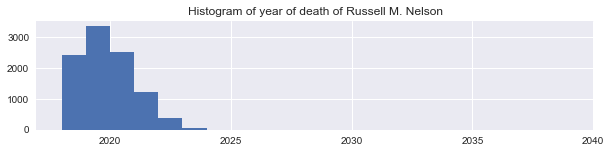

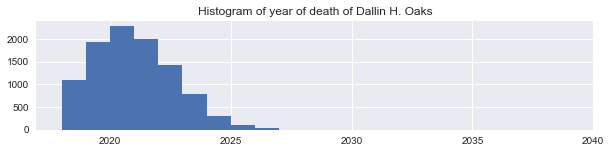

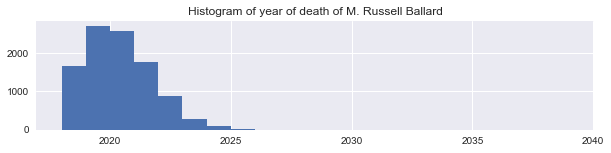

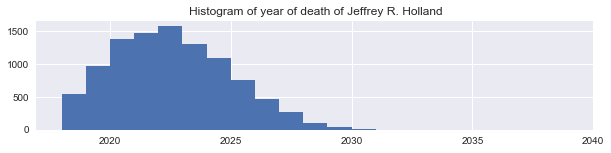

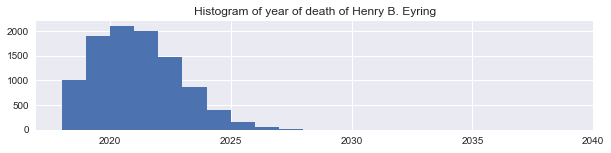

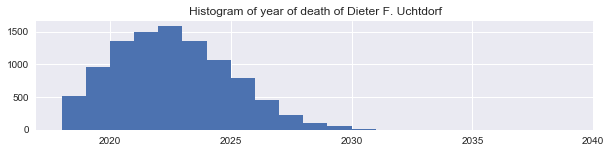

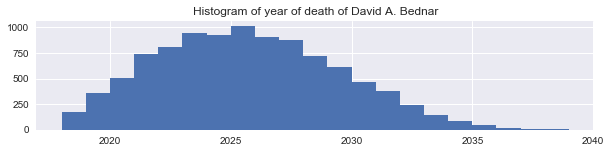

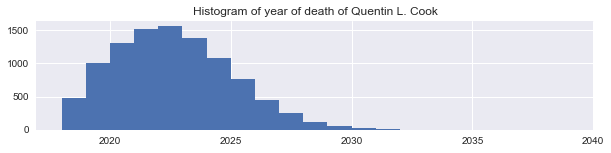

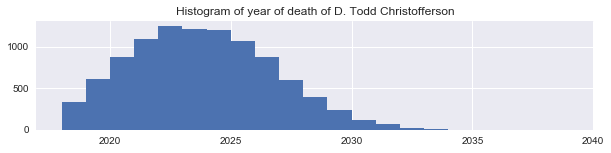

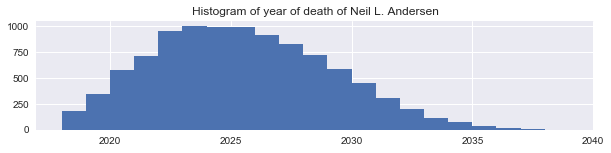

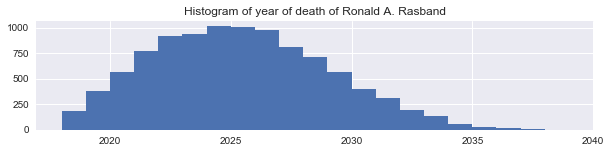

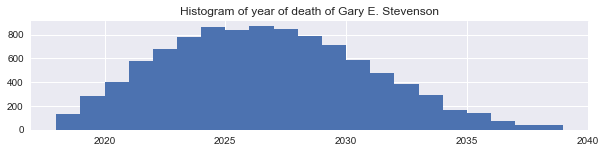

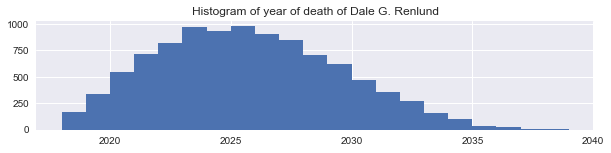

In [34]:
# Plot a histogram of each apostle's likely death years
for apostle in apostles:
    death_year_dist = []
    for i in range(10000):
        death_year_dist.append(apostle.simulate_death_year(life_table))

    plt.hist(death_year_dist,bins=range(CURRENT_YEAR,2040))
    plt.title("Histogram of year of death of {}".format(apostle.name))
    plt.show()

In [35]:
# Given our model, who is most likely to be prophet in the year 2020?
print(most_probable_prophet_in_year(apostles,2020,life_table))

Russell M. Nelson


### Method 1

In [36]:
# Given our model, who is most likely to be prophet in every year from now until 2040?
for year in range(CURRENT_YEAR,CURRENT_YEAR+25):
    print("{}: {}".format(year, most_probable_prophet_in_year(apostles,year,life_table)))

2018: Russell M. Nelson
2019: Russell M. Nelson
2020: Russell M. Nelson
2021: Dallin H. Oaks
2022: Dallin H. Oaks
2023: Jeffrey R. Holland
2024: Jeffrey R. Holland
2025: Jeffrey R. Holland
2026: Jeffrey R. Holland
2027: David A. Bednar
2028: David A. Bednar
2029: David A. Bednar
2030: David A. Bednar
2031: David A. Bednar
2032: David A. Bednar
2033: David A. Bednar
2034: David A. Bednar
2035: David A. Bednar
2036: Gary E. Stevenson
2037: Gary E. Stevenson
2038: None
2039: None
2040: None
2041: None
2042: None


### Method 2 - simulation:

What if we looked at the probabilities over 10000 trials? This would give us a
more accurate picture of how likely it is that any of the current apostles
will be prophet in any particular year. Note that it is possible (and probable)
that in some of the later years none of the current apostles will be alive. In
these cases, I have assigned a probability of prophethood to "other".

In [37]:
def run_simulation(n_trials,apostles,life_table):
    for year in range(CURRENT_YEAR,CURRENT_YEAR+25):
        prophets = defaultdict(list)
        for i in range(n_trials):
            prophet = simulate_prophet_in_year(apostles,year,life_table)
            if prophet is not None:
                prophets[prophet.name].append(1)
            else:
                prophets["other"].append(1)
        probabilities = []
        for key,count in prophets.items():
            probabilities.append((key,float(len(count))/n_trials))
        probabilities = sorted(probabilities,key=lambda x: x[1],reverse=True)
        print(year)
        for name,probability in probabilities:
            print(" {} ({})\n".format(name,probability))

In [38]:
run_simulation(10000,apostles,life_table)

2018
 Russell M. Nelson (1.0)

2019
 Russell M. Nelson (0.7563)

 Dallin H. Oaks (0.2166)

 M. Russell Ballard (0.0219)

 Jeffrey R. Holland (0.005)

 Henry B. Eyring (0.0002)

2020
 Russell M. Nelson (0.4194)

 Dallin H. Oaks (0.4024)

 M. Russell Ballard (0.104)

 Jeffrey R. Holland (0.064)

 Henry B. Eyring (0.0082)

 Dieter F. Uchtdorf (0.0018)

 David A. Bednar (0.0002)

2021
 Dallin H. Oaks (0.389)

 Jeffrey R. Holland (0.2171)

 Russell M. Nelson (0.1671)

 M. Russell Ballard (0.136)

 Henry B. Eyring (0.0478)

 Dieter F. Uchtdorf (0.0306)

 David A. Bednar (0.0108)

 D. Todd Christofferson (0.0008)

 Quentin L. Cook (0.0008)

2022
 Jeffrey R. Holland (0.3361)

 Dallin H. Oaks (0.2523)

 Dieter F. Uchtdorf (0.1123)

 Henry B. Eyring (0.0851)

 M. Russell Ballard (0.0849)

 David A. Bednar (0.0662)

 Russell M. Nelson (0.0484)

 Quentin L. Cook (0.0089)

 D. Todd Christofferson (0.0041)

 Neil L. Andersen (0.0015)

 Ronald A. Rasband (0.0002)

2023
 Jeffrey R. Holland (0.3372)

 

### Method 2  - conclusions

Interestingly, for many of the years far down the line, the apostle most likely to be prophet is far from clear.

By 2029 our model says that it is more likely that someone other than one of the current apostles will be prophet. However, since our model systematically underestimates the age of death of these men, we should take this number with a grain of salt. In 25 years there is virtually no possiblity that anyone of the apostles will be living. it's extraordinarily unlikely that any of the current apostles will still be alive. Gary E. Stevenson is the youngest apostle living and our model only predicts a .01% chance of living that long.

#### Caveats
This model did not explicitly take health state into account, but approximated it using current age. Method 3 is one way of accounting for this.

### Method 3 - adjusting for health and systematic mortality biases.
One way to approximate of actual health status is to adjust their ages to reflect both their current health and the greater-than-average overall health of their demographic.

In [65]:
default = 5
apostle_age_adjustments = {
    # All defaults - church has done a solid job limiting news of apostles health
    "Russell M. Nelson":  default,
    "Dallin H. Oaks":     default,
    "M. Russell Ballard": default,
    "Jeffrey R. Holland": default,
    "Henry B. Eyring":    default,
    "Dieter F. Uchtdorf": default,
    "David A. Bednar":    default,
    "Quentin L. Cook":    default,
    "D. Todd Christofferson": default,
    "Neil L. Andersen":   default,
    "Ronald A. Rasband": default,
    "Gary E. Stevenson": default,
    "Dale G. Renlund": default,
}

In [66]:
adj_apostles = []
for apostle in apostles:
    adg_adj = apostle_age_adjustments[apostle.name]
    adj_apostles.append(Apostle(
        apostle.name,
        (a.birth + timedelta(days=8*365)),
        apostle.twelve,
        apostle.ordained,
        apostle.seniority))     

In [67]:
run_simulation(10000,adj_apostles,life_table)

2018
 Russell M. Nelson (1.0)

2019
 Russell M. Nelson (0.8898)

 Dallin H. Oaks (0.0988)

 M. Russell Ballard (0.0104)

 Jeffrey R. Holland (0.0009)

 Henry B. Eyring (0.0001)

2020
 Russell M. Nelson (0.6929)

 Dallin H. Oaks (0.2106)

 M. Russell Ballard (0.0678)

 Jeffrey R. Holland (0.0202)

 Henry B. Eyring (0.0057)

 Dieter F. Uchtdorf (0.0019)

 David A. Bednar (0.0006)

 Quentin L. Cook (0.0003)

2021
 Russell M. Nelson (0.4593)

 Dallin H. Oaks (0.2415)

 M. Russell Ballard (0.1415)

 Jeffrey R. Holland (0.0744)

 Henry B. Eyring (0.038)

 Dieter F. Uchtdorf (0.0215)

 David A. Bednar (0.0115)

 Quentin L. Cook (0.0056)

 D. Todd Christofferson (0.0037)

 Neil L. Andersen (0.0017)

 Ronald A. Rasband (0.0008)

 other (0.0003)

 Dale G. Renlund (0.0001)

 Gary E. Stevenson (0.0001)

2022
 Russell M. Nelson (0.2593)

 Dallin H. Oaks (0.1952)

 M. Russell Ballard (0.1424)

 Jeffrey R. Holland (0.1082)

 Henry B. Eyring (0.0755)

 Dieter F. Uchtdorf (0.0584)

 David A. Bednar (0.